In [18]:
# import standard libraries
import regex as re
from glob import glob
import numpy as np
# third-party libraries
import dask
import dask.dataframe as dd
import dask.multiprocessing
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
# local libraries
from fbd import read_parquet, plot_dendrogram

# Data

In [5]:
filenames = glob('data/loadings/*.parquet')

In [6]:
len(filenames)

2497

In [7]:
dates = [re.findall(r'\d{4}-\d{2}-\d{2}', f)[0] for f in filenames]
dates_dt = pd.to_datetime(dates).sort_values()
dates_str = dates_dt.strftime('%Y-%m-%d')

In [8]:
# get filenames again in correct order
filenames = [glob(f'data/loadings/{d}.parquet')[0] for d in dates_str]

In [9]:
const_mat = pd.read_csv('data/russell3000.csv.gz', compression='gzip',
                        index_col=0)

In [10]:
permnos = const_mat.columns.values

## Clean company information

In [11]:
info = pd.read_csv('data/permno_info.csv.gz', compression='gzip',
                   index_col=0)

info['permno'] = info['permno'].astype(int).astype(str)
# get rid of nan in naics
info.dropna(how='any', subset=['naics'], inplace=True)
# remove duplicate rows from info
info.drop_duplicates(subset=['permno'], inplace=True, keep='last', ignore_index=True)

# get sector from naics
info['naics'] = info['naics'].astype(int).astype(str)
info['sector'] = info['naics'].str[:2]
info[['naics', 'sector']] = info[['naics', 'sector']].astype(int)

# we won't be needing siccd actually
info.drop(columns=['siccd'], inplace=True)

# set permno to index
info.set_index('permno', inplace=True)

In [12]:
info.isna().sum()

comnam     0
naics      0
ticker    12
sector     0
dtype: int64

In [13]:
# missing info securities
missing_permnos = list(set(permnos) - set(info.index.values))
missing_permnos

['92615',
 '14065',
 '17782',
 '19148',
 '18363',
 '15044',
 '15120',
 '14712',
 '18579',
 '18151',
 '16877',
 '14669',
 '14271',
 '15829',
 '14247',
 '18807',
 '14789',
 '19084',
 '13250',
 '14643',
 '92494',
 '91638']

# Clustering

In [14]:
num_sectors = len(info['sector'].unique())
num_sectors

24

In [22]:
def compute_clusters(i):
    f = filenames[i]
    t = dates_str[i]
    loadings = read_parquet(f)
    loadings.dropna(how='all', axis=1, inplace=True)
    # get permnos as observations to cluster
    loadings_t = loadings.T
    # perform agglomerative clustering using ward linkage
    ac = AgglomerativeClustering(n_clusters=num_sectors, linkage='ward')
    ac = ac.fit(loadings_t)
    labels = pd.DataFrame(columns=[t], index=loadings_t.index, data=ac.labels_)
    # filter loadings according to index in info (get rid of permnos that are in loadings and not in info)
    labels = labels[labels.index.isin(info.index)]
    return labels

In [23]:
# default setting for Dask
dask.config.set(scheduler='processes')

In [24]:
%%time
with ProgressBar():
    promises = [dask.delayed(compute_clusters)(i) for i, _ in enumerate(filenames)]
    all_labels = dask.compute(promises)[0]

[########################################] | 100% Completed |  2min 35.2s
CPU times: user 24.7 s, sys: 2.27 s, total: 26.9 s
Wall time: 2min 35s


In [29]:
info_labels = pd.concat([info] + all_labels, axis=1, ignore_index=False)

In [30]:
# save to parquet
info_labels.columns = info_labels.columns.astype(str)
info_labels.index = info_labels.index.astype(str)
info_labels.to_parquet('data/clustering/agglomerative_ward.parquet')

In [35]:
info_labels

,comnam,naics,ticker,sector,2010-02-01,2010-02-02,2010-02-03,2010-02-04,2010-02-05,2010-02-08,...,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-26,2019-12-27,2019-12-30,2019-12-31
10026,J & J SNACK FOODS CORP,311813,JJSF,31,18.0,13.0,6.0,19.0,11.0,20.0,...,20.0,0.0,5.0,9.0,18.0,8.0,1.0,21.0,13.0,9.0
10032,PLEXUS CORP,334418,PLXS,33,15.0,23.0,3.0,0.0,20.0,8.0,...,0.0,0.0,5.0,6.0,6.0,2.0,3.0,18.0,16.0,3.0
10051,HANGER INC,339113,HNGR,33,16.0,1.0,11.0,4.0,17.0,0.0,...,18.0,4.0,22.0,2.0,11.0,0.0,6.0,21.0,13.0,3.0
10065,ADAMS EXPRESS CO,525910,ADX,52,3.0,17.0,22.0,9.0,7.0,8.0,...,18.0,2.0,11.0,3.0,2.0,22.0,1.0,18.0,8.0,3.0
10104,ORACLE CORP,511210,ORCL,51,3.0,3.0,22.0,9.0,10.0,14.0,...,18.0,4.0,5.0,5.0,18.0,8.0,1.0,18.0,10.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93428,BROADSOFT INC,511210,BSFT,51,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93429,C B O E GLOBAL MARKETS INC,523210,CBOE,52,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,7.0,5.0,6.0,13.0,8.0,8.0,18.0,8.0,3.0
93431,PACTERA TECHNOLOGY INTL LTD,541512,PACT,54,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93433,VOLTARI CORP,511210,VLTC,51,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dendogram 

In [32]:
# load some loadings
f = filenames[0]
t = dates_str[0]
loadings = read_parquet(f)
loadings.dropna(how='all', axis=1, inplace=True)
loadings_t = loadings.T

In [33]:
ac = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
ac = ac.fit(loadings_t)

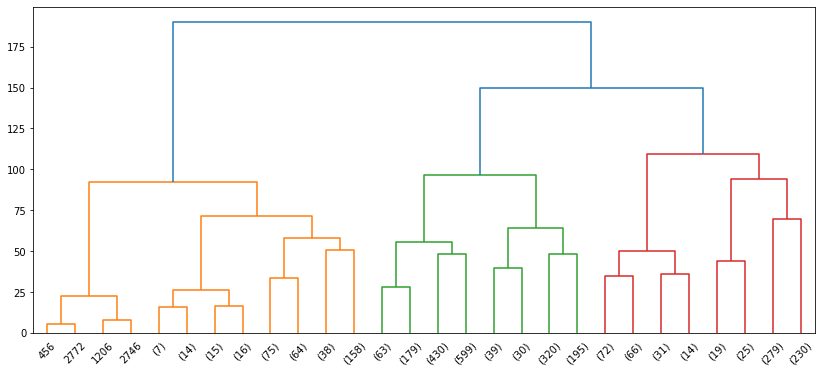

In [34]:
fig, ax = plt.subplots(figsize=(14, 6))
plot_dendrogram(ac, truncate_mode='level', p=4, ax=ax)